## Part 1:

### Defining Business Problem

Whenever we visit a new place, we want to enjoy the fullest in a very short span of time and as cheap as it can be. A major part of our expenses is on hotels and travelling cost from hotels to tourist sites. If we were able to select the perfect place to stay with good venues nearby, and everything falls in our budget, that would make a most enjoyable trip. Let us try to analyse the data for the city of Mumbai, India, A famous and costly tourist location for both domestic and international travellers. We will be using the Foursquare API and the TripAdvisor API to get the data for hotels and their nearbuy venues.

Let's get started with it.

### Defining Data

We will first of all need hotels data for Mumbai city and will retrieve it using the TripAdvisor API. Our data should contain the name of the hotel, it's co-ordinates, it's rating, price details. Some details varies a lot based on the check-in and check-out dates, for eg. when we opt for longer stays, some hotels give discounts or prices fluctuate due to festivals of time of the year, also on how well ahead is the trip planned. We will analyse all of these in the coming sections.

After shortlisting a handful of hotels, we will be needing details of nearbuy venues to compare different hotels. We will extract this information using Foursquare API. 

Let us go ahead and extract all these.

In [47]:
from datetime import datetime
from time import time
from lxml import html,etree
import requests,re
import os,sys
import unicodecsv as csv
import argparse

def parse(locality,checkin_date,checkout_date,sort):
    checkIn = checkin_date.strftime("%Y/%m/%d")
    checkOut = checkout_date.strftime("%Y/%m/%d")
    print ("Scraper Inititated for Locality:%s"%locality)
    # TA rendering the autocomplete list using this API
    print ("Finding search result page URL")
    geo_url = 'https://www.tripadvisor.com/TypeAheadJson?action=API&startTime='+str(int(time()))+'&uiOrigin=GEOSCOPE&source=GEOSCOPE&interleaved=true&types=geo,theme_park&neighborhood_geos=true&link_type=hotel&details=true&max=12&injectNeighborhoods=true&query='+locality
    api_response  = requests.get(geo_url, verify=False).json()
    #getting the TA url for th equery from the autocomplete response
    url_from_autocomplete = "http://www.tripadvisor.com"+api_response['results'][0]['url']
    print ('URL found %s'%url_from_autocomplete)
    geo = api_response['results'][0]['value']   
    #Formating date for writing to file 
    
    date = checkin_date.strftime("%Y_%m_%d")+"_"+checkout_date.strftime("%Y_%m_%d")
    #form data to get the hotels list from TA for the selected date
    form_data = {'changeSet': 'TRAVEL_INFO',
            'showSnippets': 'false',
            'staydates':date,
            'uguests': '2',
            'sortOrder':sort
    }
    #Referrer is necessary to get the correct response from TA if not provided they will redirect to home page
    headers = {
                            'Accept': 'text/javascript, text/html, application/xml, text/xml, */*',
                            'Accept-Encoding': 'gzip,deflate',
                            'Accept-Language': 'en-US,en;q=0.5',
                            'Cache-Control': 'no-cache',
                            'Connection': 'keep-alive',
                            'Content-Type': 'application/x-www-form-urlencoded; charset=utf-8',
                            'Host': 'www.tripadvisor.com',
                            'Pragma': 'no-cache',
                            'Referer': url_from_autocomplete,
                            'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:28.0) Gecko/20100101 Firefox/28.0',
                            'X-Requested-With': 'XMLHttpRequest'
                        }
    cookies=  {"SetCurrency":"USD"}
    print ("Downloading search results page")
    page_response  = requests.post(url = url_from_autocomplete,data=form_data,headers = headers, cookies = cookies, verify=False)
    print ("Parsing results ")
    parser = html.fromstring(page_response.text)
    hotel_lists = parser.xpath('//div[contains(@class,"listItem")]//div[contains(@class,"listing collapsed")]')
    hotel_data = []
    if not hotel_lists:
        hotel_lists = parser.xpath('//div[contains(@class,"listItem")]//div[@class="listing "]')

    for hotel in hotel_lists:
        XPATH_HOTEL_LINK = './/a[contains(@class,"property_title")]/@href'
        XPATH_REVIEWS  = './/a[@class="review_count"]//text()'
        XPATH_RANK = './/div[@class="popRanking"]//text()'
        XPATH_RATING = './/span[contains(@class,"rating")]/@alt'
        XPATH_HOTEL_NAME = './/a[contains(@class,"property_title")]//text()'
        XPATH_HOTEL_FEATURES = './/div[contains(@class,"common_hotel_icons_list")]//li//text()'
        XPATH_HOTEL_PRICE = './/div[contains(@data-sizegroup,"mini-meta-price")]/text()'
        XPATH_VIEW_DEALS = './/div[contains(@data-ajax-preserve,"viewDeals")]//text()' 
        XPATH_BOOKING_PROVIDER = './/div[contains(@data-sizegroup,"mini-meta-provider")]//text()'

        raw_booking_provider = hotel.xpath(XPATH_BOOKING_PROVIDER)
        raw_no_of_deals =  hotel.xpath(XPATH_VIEW_DEALS)
        raw_hotel_link = hotel.xpath(XPATH_HOTEL_LINK)
        raw_no_of_reviews = hotel.xpath(XPATH_REVIEWS)
        raw_rank = hotel.xpath(XPATH_RANK)
        raw_rating = hotel.xpath(XPATH_RATING)
        raw_hotel_name = hotel.xpath(XPATH_HOTEL_NAME)
        raw_hotel_features = hotel.xpath(XPATH_HOTEL_FEATURES)
        raw_hotel_price_per_night  = hotel.xpath(XPATH_HOTEL_PRICE)

        url = 'http://www.tripadvisor.com'+raw_hotel_link[0] if raw_hotel_link else  None
        reviews = ''.join(raw_no_of_reviews).replace("reviews","").replace(",","") if raw_no_of_reviews else 0 
        rank = ''.join(raw_rank) if raw_rank else None
        rating = ''.join(raw_rating).replace('of 5 bubbles','').strip() if raw_rating else None
        name = ''.join(raw_hotel_name).strip() if raw_hotel_name else None
        hotel_features = ','.join(raw_hotel_features)
        price_per_night = ''.join(raw_hotel_price_per_night).replace('\n','') if raw_hotel_price_per_night else None
        no_of_deals = re.findall("all\s+?(\d+)\s+?",''.join(raw_no_of_deals))
        booking_provider = ''.join(raw_booking_provider).strip() if raw_booking_provider else None

        if no_of_deals:
            no_of_deals = no_of_deals[0]
        else:
            no_of_deals = 0
            
        data = {
                    'hotel_name':name,
                    'url':url,
                    'locality':locality,
                    'reviews':reviews,
                    'tripadvisor_rating':rating,
                    'checkOut':checkOut,
                    'checkIn':checkIn,
                    'hotel_features':hotel_features,
                    'price_per_night':price_per_night,
                    'no_of_deals':no_of_deals,
                    'booking_provider':booking_provider

        }
        hotel_data.append(data)
    return hotel_data


locality = 'Mumbai'
checkin_date = datetime.strptime('2021/04/10',"%Y/%m/%d")
checkout_date = datetime.strptime('2021/04/15',"%Y/%m/%d")
sort = 'popularity'
today = datetime.now()
checkIn = checkin_date.strftime("%Y/%m/%d")
checkOut = checkout_date.strftime("%Y/%m/%d")


if today<datetime.strptime(checkIn,"%Y/%m/%d") and datetime.strptime(checkIn,"%Y/%m/%d")<datetime.strptime(checkOut,"%Y/%m/%d"):
    data = parse(locality,checkin_date,checkout_date,sort)
    print ("Writing to output file tripadvisor_data.csv")
    with open('tripadvisor_data.csv','wb')as csvfile:
        fieldnames = ['hotel_name','url','locality','reviews','tripadvisor_rating','checkIn','checkOut','price_per_night','booking_provider','no_of_deals','hotel_features']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for row in  data:
            writer.writerow(row)
#checking whether the entered date is already passed
elif today>datetime.strptime(checkIn,"%Y/%m/%d") or today>datetime.strptime(checkOut,"%Y/%m/%d"):
    print ("Invalid Checkin date: Please enter a valid checkin and checkout dates,entered date is already passed")

elif datetime.strptime(checkIn,"%Y/%m/%d")>datetime.strptime(checkOut,"%Y/%m/%d"):
    print ("Invalid Checkin date: CheckIn date must be less than checkOut date")

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('checkin_date',help = 'Hotel Check In Date (Format: YYYY/MM/DD')
#     parser.add_argument('checkout_date',help = 'Hotel Chek Out Date (Format: YYYY/MM/DD)')
#     sortorder_help = """
#     available sort orders are :\n
#     priceLow - hotels with lowest price,
#     distLow : Hotels located near to the search center,
#     recommended: highest rated hotels based on traveler reviews,
#     popularity :Most popular hotels as chosen by Tipadvisor users 
#     """
#     parser.add_argument('sort',help = sortorder_help,default ='popularity ')
#     parser.add_argument('locality',help = 'Search Locality')
#     args = parser.parse_args()
#     locality = args.locality
#     checkin_date = datetime.strptime(args.checkin_date,"%Y/%m/%d")
#     checkout_date = datetime.strptime(args.checkout_date,"%Y/%m/%d")
#     sort= args.sort
#     checkIn = checkin_date.strftime("%Y/%m/%d")
#     checkOut = checkout_date.strftime("%Y/%m/%d")
#     today = datetime.now()
   
#     if today<datetime.strptime(checkIn,"%Y/%m/%d") and datetime.strptime(checkIn,"%Y/%m/%d")<datetime.strptime(checkOut,"%Y/%m/%d"):
#         data = parse(locality,checkin_date,checkout_date,sort)
#         print "Writing to output file tripadvisor_data.csv"
#         with open('tripadvisor_data.csv','w')as csvfile:
#             fieldnames = ['hotel_name','url','locality','reviews','tripadvisor_rating','checkIn','checkOut','price_per_night','booking_provider','no_of_deals','hotel_features']
#             writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#             writer.writeheader()
#             for row in  data:
#                 writer.writerow(row)
#     #checking whether the entered date is already passed
#     elif today>datetime.strptime(checkIn,"%Y/%m/%d") or today>datetime.strptime(checkOut,"%Y/%m/%d"):
#         print "Invalid Checkin date: Please enter a valid checkin and checkout dates,entered date is already passed"
    
#     elif datetime.strptime(checkIn,"%Y/%m/%d")>datetime.strptime(checkOut,"%Y/%m/%d"):
#         print "Invalid Checkin date: CheckIn date must be less than checkOut date"

Scraper Inititated for Locality:Mumbai
Finding search result page URL


C:\Users\niharika.a.kumari\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.tripadvisor.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


URL found http://www.tripadvisor.com/Hotels-g304554-Mumbai_Maharashtra-Hotels.html


C:\Users\niharika.a.kumari\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.tripadvisor.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Parsing results 
Writing to output file tripadvisor_data.csv


In [69]:
import pandas as pd
tripadvisor_data = pd.read_csv("tripadvisor_data.csv")

print(len(tripadvisor_data))
tripadvisor_data.head()

30


,hotel_name,url,locality,reviews,tripadvisor_rating,checkIn,checkOut,price_per_night,booking_provider,no_of_deals,hotel_features
0,"Trident, Nariman Point",http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,5200,NaN,2021/04/10,2021/04/15,$79,MakeMyTrip,11,"Free parking ,Pool ,Visit hotel website"
1,Sofitel Mumbai BKC,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,6940,NaN,2021/04/10,2021/04/15,$63,MakeMyTrip,11,"Free Wifi ,Free parking"
2,"Trident, Bandra Kurla, Mumbai",http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,4730,NaN,2021/04/10,2021/04/15,$69,MakeMyTrip,12,"Free Wifi ,Free parking ,Visit hotel website"
3,Sahara Star Hotel,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,4634,NaN,2021/04/10,2021/04/15,$52,MakeMyTrip,9,"Free parking ,Pool"
4,Grand Hyatt Mumbai Hotel & Residences,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,5226,NaN,2021/04/10,2021/04/15,$59,MakeMyTrip,12,"Free Wifi ,Free parking ,Visit hotel website"


In [70]:
from geopy.geocoders import Nominatim

In [71]:
def get_lat_long(address):

    geolocator = Nominatim(user_agent="india_explorer")
    location = geolocator.geocode(address)
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
        return latitude, longitude
    else:
        return None, None

In [72]:
for index, row in tripadvisor_data.iterrows():
    lat, long = get_lat_long(row['hotel_name']+', Mumbai')
    tripadvisor_data.at[index, 'Latitude'] = lat
    tripadvisor_data.at[index, 'Longitude'] = long

In [73]:
tripadvisor_data

,hotel_name,url,locality,reviews,tripadvisor_rating,checkIn,checkOut,price_per_night,booking_provider,no_of_deals,hotel_features,Latitude,Longitude
0,"Trident, Nariman Point",http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,5200,NaN,2021/04/10,2021/04/15,$79,MakeMyTrip,11,"Free parking ,Pool ,Visit hotel website",18.927874,72.821163
1,Sofitel Mumbai BKC,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,6940,NaN,2021/04/10,2021/04/15,$63,MakeMyTrip,11,"Free Wifi ,Free parking",NaN,NaN
2,"Trident, Bandra Kurla, Mumbai",http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,4730,NaN,2021/04/10,2021/04/15,$69,MakeMyTrip,12,"Free Wifi ,Free parking ,Visit hotel website",19.066699,72.867947
3,Sahara Star Hotel,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,4634,NaN,2021/04/10,2021/04/15,$52,MakeMyTrip,9,"Free parking ,Pool",19.095629,72.853990
4,Grand Hyatt Mumbai Hotel & Residences,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,5226,NaN,2021/04/10,2021/04/15,$59,MakeMyTrip,12,"Free Wifi ,Free parking ,Visit hotel website",NaN,NaN
5,The Leela Mumbai,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,4483,NaN,2021/04/10,2021/04/15,$48,MakeMyTrip,11,"Free parking ,Pool ,Visit hotel website",19.109243,72.873758
6,"Taj Lands End, Mumbai",http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,4861,NaN,2021/04/10,2021/04/15,$76,MakeMyTrip,11,"Free Wifi ,Free parking",19.043396,72.819529
7,The Fern - Goregaon,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,1001,NaN,2021/04/10,2021/04/15,$40,MakeMyTrip,12,"Free Wifi ,Free parking",NaN,NaN
8,Lemon Tree Premier-Mumbai International Airport,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,461,NaN,2021/04/10,2021/04/15,$33,MakeMyTrip,9,"Free Wifi ,Free parking",NaN,NaN
9,Hilton Mumbai International Airport,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,2364,NaN,2021/04/10,2021/04/15,$48,MakeMyTrip,9,"Free parking ,Pool",19.104370,72.870935


For some locations, we are not able to retrieve the latitude, longitude values for the geopy library, let's ignore these places. 

Also, the rating column is NA for all hotels, but since we have sorted by popularity and owing to my background knowledge of Mumbai area and hotels, I know all of these are 5 star hotels. so, for siplicity, let us drop the rating column from our dataset.

In [74]:
tripadvisor_data = tripadvisor_data.drop('tripadvisor_rating',axis = 1)
tripadvisor_data = tripadvisor_data.dropna()
tripadvisor_data.head()

,hotel_name,url,locality,reviews,checkIn,checkOut,price_per_night,booking_provider,no_of_deals,hotel_features,Latitude,Longitude
0,"Trident, Nariman Point",http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,5200,2021/04/10,2021/04/15,$79,MakeMyTrip,11,"Free parking ,Pool ,Visit hotel website",18.927874,72.821163
2,"Trident, Bandra Kurla, Mumbai",http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,4730,2021/04/10,2021/04/15,$69,MakeMyTrip,12,"Free Wifi ,Free parking ,Visit hotel website",19.066699,72.867947
3,Sahara Star Hotel,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,4634,2021/04/10,2021/04/15,$52,MakeMyTrip,9,"Free parking ,Pool",19.095629,72.853990
5,The Leela Mumbai,http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,4483,2021/04/10,2021/04/15,$48,MakeMyTrip,11,"Free parking ,Pool ,Visit hotel website",19.109243,72.873758
6,"Taj Lands End, Mumbai",http://www.tripadvisor.com/Hotel_Review-g30455...,Mumbai,4861,2021/04/10,2021/04/15,$76,MakeMyTrip,11,"Free Wifi ,Free parking",19.043396,72.819529


In [75]:
print(tripadvisor_data.shape)
print("Thus we have all required data for {} five star hotels in Mumbai".format(tripadvisor_data.shape[0]))

(12, 12)
Thus we have all required data for 12 five star hotels in Mumbai


In [76]:
tripadvisor_data.to_csv("Tripadvisior_all_data_new.csv",index=False)

Now, using the foursquare API we will extract all venues within 1 km radius of these hotels.

But before that, let us view our hotels on Mumbai Map.

In [77]:
import folium
# create map of Mumbai using latitude and longitude values
latitude, longitude = 19.0760, 72.8777
map_mum = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, hotel in zip(tripadvisor_data['Latitude'], tripadvisor_data['Longitude'], tripadvisor_data['hotel_name']):
    label = '{}'.format(hotel)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

Since the github nb does not show folium maps, adding a screenshot of it in markdown
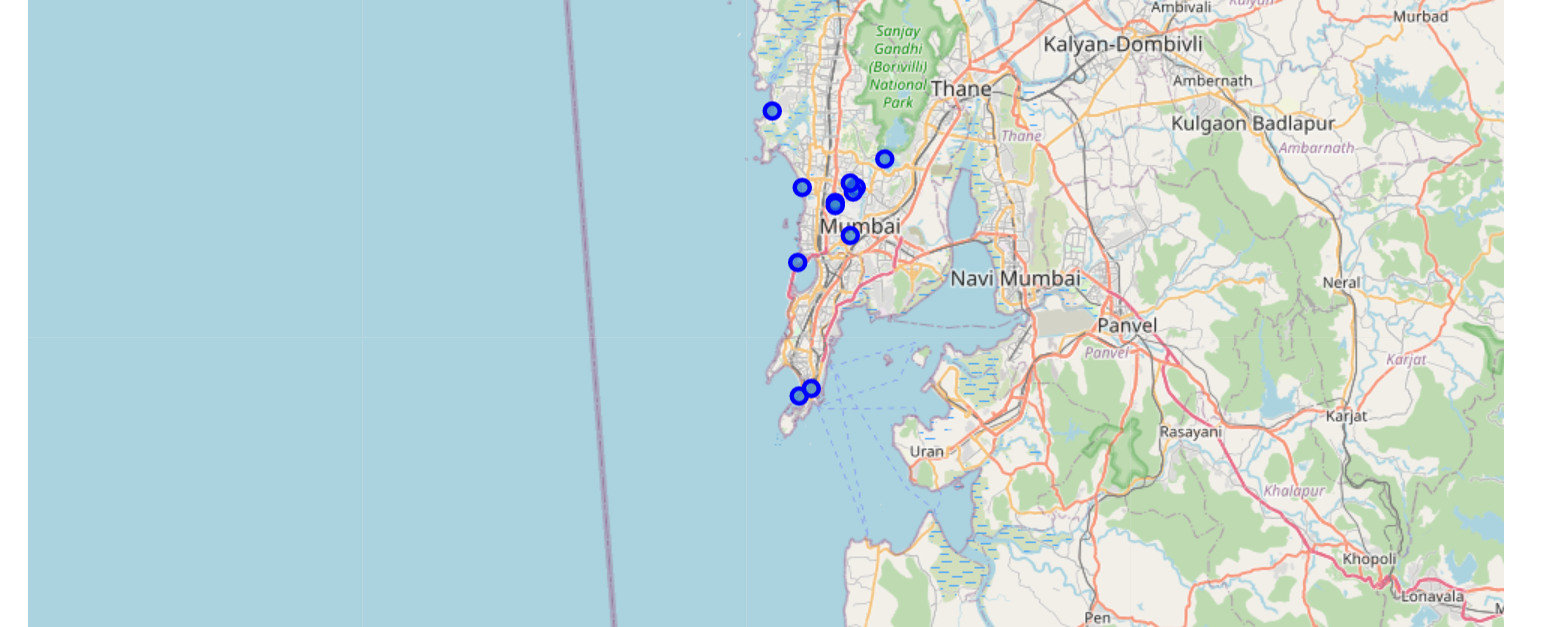

In [78]:
# Let us start getting the venue information for our neighbourhoods using foursquare api. For this we first define the credentials
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [79]:
#here we place a call to foursquare api to get venue info for all neighbourhoods

def getNearbyVenues(names,price,no_of_deals, hotel_features , latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, price_per_night,no_of_deals,hotel_features, lat, lng in zip(names, price,no_of_deals, hotel_features , latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            price_per_night,
            no_of_deals,
            hotel_features,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hotel Name', 
                  'Price Per Night',
                  'No of deals',
                  'Hotel Features',
                  'Hotel Latitude', 
                  'Hotel Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

radius = 1000
mumbai_venues = getNearbyVenues(tripadvisor_data['hotel_name'],tripadvisor_data['price_per_night'],tripadvisor_data['no_of_deals'],tripadvisor_data['hotel_features'], tripadvisor_data['Latitude'], tripadvisor_data['Longitude'],  radius)
mumbai_venues

,Hotel Name,Price Per Night,No of deals,Hotel Features,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Trident, Nariman Point",$79,11,"Free parking ,Pool ,Visit hotel website",18.927874,72.821163,Nariman Point,18.929183,72.822232,Scenic Lookout
1,"Trident, Nariman Point",$79,11,"Free parking ,Pool ,Visit hotel website",18.927874,72.821163,The Sassy Spoon,18.928426,72.822512,Diner
2,"Trident, Nariman Point",$79,11,"Free parking ,Pool ,Visit hotel website",18.927874,72.821163,Trident,18.927878,72.820711,Hotel
3,"Trident, Nariman Point",$79,11,"Free parking ,Pool ,Visit hotel website",18.927874,72.821163,The Oberoi,18.927101,72.820165,Hotel
4,"Trident, Nariman Point",$79,11,"Free parking ,Pool ,Visit hotel website",18.927874,72.821163,National Centre for the Performing Arts (NCPA),18.925631,72.819861,Performing Arts Venue
...,...,...,...,...,...,...,...,...,...,...
717,Renaissance Mumbai Convention Centre Hotel,$46,12,"Free parking ,Pool ,Visit hotel website",19.133532,72.900112,Herb & Spice,19.135816,72.898596,Coffee Shop
718,Renaissance Mumbai Convention Centre Hotel,$46,12,"Free parking ,Pool ,Visit hotel website",19.133532,72.900112,Cafe Ambrosia,19.135795,72.898502,Restaurant
719,Renaissance Mumbai Convention Centre Hotel,$46,12,"Free parking ,Pool ,Visit hotel website",19.133532,72.900112,Mantra Dining Bar,19.126459,72.901452,Restaurant
720,Renaissance Mumbai Convention Centre Hotel,$46,12,"Free parking ,Pool ,Visit hotel website",19.133532,72.900112,L&T Canteen LR2,19.129449,72.896191,Food Court


In [80]:
mumbai_venues.to_csv("Mumbai_Venues_new.csv",index=False)

Hotel features play a significant role for a lot of travellers to decide on what hotel to opt. Let us spend some time analysing what information this column provides us. We need to observe if it can be used to comparing different hotels or not.

In [85]:
mumbai_venues['Hotel Features'].unique()

array(['Free parking ,Pool ,Visit hotel website ',
       'Free Wifi ,Free parking ,Visit hotel website ',
       'Free parking ,Pool ', 'Free Wifi ,Free parking '], dtype=object)

There are only 4 unique set of features in our dataset, and we see that they do not differ a lot. The major points are
1. Free Parking,
2. Pool, and
3. Free Wifi. 

We can conclude that they may not play a very significant part in deciding upon the hotel. Thus, we can go ahead and drop this column as well.

In [87]:
mumbai_venues = mumbai_venues.drop("Hotel Features", axis=1)
mumbai_venues.head()

,Hotel Name,Price Per Night,No of deals,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Trident, Nariman Point",$79,11,18.927874,72.821163,Nariman Point,18.929183,72.822232,Scenic Lookout
1,"Trident, Nariman Point",$79,11,18.927874,72.821163,The Sassy Spoon,18.928426,72.822512,Diner
2,"Trident, Nariman Point",$79,11,18.927874,72.821163,Trident,18.927878,72.820711,Hotel
3,"Trident, Nariman Point",$79,11,18.927874,72.821163,The Oberoi,18.927101,72.820165,Hotel
4,"Trident, Nariman Point",$79,11,18.927874,72.821163,National Centre for the Performing Arts (NCPA),18.925631,72.819861,Performing Arts Venue


Now, we have our dataset ready. We can do some more exploration here using graphs and charts. Let's see the importance of these columns. 

In [91]:
# mumbai_venues.bar(x='Hotel Name', y='Price Per Night')

# import matplotlib.pyplot as plt
# ax = mumbai_venues[['Hotel Name','Price Per Night']].plot(kind='bar', title ="Price Comparison", figsize=(15, 10), legend=True, fontsize=12)
# ax.set_xlabel("Hotels", fontsize=12)
# ax.set_ylabel("Price", fontsize=12)
# plt.show()